# Part 3: Monte Carlo Sampling

In this final tutorial, we will:
- Implement Monte Carlo sampling for larger systems
- Compute local energies using sparse operator connections
- Estimate energies and gradients from samples
- Build a complete VMC optimization loop
- Explore advanced optimizers and future extensions

This tutorial builds on the concepts from Parts 1 and 2, extending to the Monte Carlo regime where full summation over the Hilbert space is no longer feasible.

:::{note}
If you are executing this notebook on **Colab**, you will need to install NetKet:
:::

In [5]:
# Import necessary libraries
import platform
import netket as nk
import numpy as np
from tqdm.auto import tqdm
from functools import partial

# jax and jax.numpy
import jax
import jax.numpy as jnp

# Flax for neural network models
import flax.linen as nn

print("Python version (requires >=3.9)", platform.python_version())
print("NetKet version (requires >=3.9.1)", nk.__version__)

Python version (requires >=3.9) 3.13.7
NetKet version (requires >=3.9.1) 3.19.2


## 1. Setup from Previous Tutorials

On étudie le modèle d'Ising en deux dimensions à $h/J = 3.044$:
$$H = -J \sum_{\langle i j \rangle} \sigma_i^z \sigma_j^z -h \sum_{i}\sigma_i^x$$
où la relation $\langle i j \rangle$ indique des sites voisins sur le réseau (ici carré).

In [30]:
# Define the system
L = 3
g = nk.graph.Grid(extent=[L,L], pbc=True)
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes, inverted_ordering=True)

# Build the Hamiltonian
hamiltonian = nk.operator.Ising(hi, g, h=3.044, J=1.0)

# Convert to JAX format
hamiltonian_jax = hamiltonian.to_jax_operator()

# Compute exact ground state for comparison
from scipy.sparse.linalg import eigsh

e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=2, which = 'SA')
print(e_gs)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)

print(f"Exact ground state energy: {e_gs:.6f}")

[-28.69887525 -24.25591504]
Exact ground state energy: -28.698875


## 2. Variational Models
On définit ici un ansatz de champ moyen et un ansatz de Jastrow, ainsi que la Machine de Boltzmann Restreinte (RBM, ici l'implémentation de netket).

**Remarque : ** Dans Netket (et de façon plus générale), on encode le logarithme des fonctions d'onde $\log \psi_\theta$, c'est pourquoi on retrouve une somme dans l'ansatz de champ moyen. Il y a deux raisons principales à cela :
- les amplitudes des fonctions d'onde s'étendent généralement sur plusieurs ordres de grandeur, rendant l'apprentissage plus difficile pour un réseau de neurone, et posant le risque d'erreur numériques accrues.
- Lorsqu'on calcule le gradient par méthode de Monte Carlo, on doit dériver $\log \psi_\theta$ directement.


In [7]:
# Mean Field Ansatz
class MF(nn.Module):
    @nn.compact
    def __call__(self, x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        p = nn.log_sigmoid(lam * x)
        return 0.5 * jnp.sum(p, axis=-1)


# Jastrow Ansatz
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        J = self.param("J", nn.initializers.normal(), (n_sites, n_sites), float)
        dtype = jax.numpy.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)
        J_symm = J.T + J
        return jnp.einsum("...i,ij,...j", x, J_symm, x)

In [8]:
mf_wf = MF()
mf_pars = mf_wf.init(jax.random.key(4), jnp.zeros((L,)))

ja_wf = Jastrow()
ja_pars = ja_wf.init(jax.random.key(4), jnp.zeros((L,)))

In [9]:
xs = hi.all_states()

xs

Array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1,  1, -1],
       ...,
       [ 1,  1,  1, ...,  1, -1,  1],
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

In [10]:
mf_wf.apply(mf_pars, xs)

Array([-6.99531813, -6.98895375, -6.98895375, ..., -6.87439491,
       -6.87439491, -6.86803053], dtype=float64)

In [11]:
# Implémentation machine de Boltzmann

class BM(nn.Module):
    
    alpha: float     

    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        n_hidden = int(self.alpha * n_sites)

        W = self.param("W", nn.initializers.normal(), (n_sites, n_hidden), jnp.complex128)
        b = self.param("b", nn.initializers.normal(), (n_hidden,), jnp.complex128)
        
        return jnp.sum(jnp.log(jnp.cosh(jnp.matmul(x,W)+b)),axis=-1)

In [ ]:
# Implémentation machine de Boltzmann en rajoutant avant une couche ReLU
class BM_ReLU(nn.Module) : 
    alpha: float   
    beta : float 
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        n_hidden_2 = int(self.beta * n_sites)
        n_hidden_1 = int(self.alpha * n_sites)
        
        W_1 = self.param("W_1", nn.initializers.normal(), (n_sites, n_hidden_1), jnp.complex128)
        b_1 = self.param("b_1", nn.initializers.normal(), (n_hidden_1, ), jnp.complex128)

        W_2 = self.param("W_2", nn.initializers.normal(), (n_hidden_1, n_hidden_2), jnp.complex128)
        b_2 = self.param("b_2", nn.initializers.normal(), (n_hidden_2,), jnp.complex128)
        
        layer_1 = nn.relu(jnp.dot(x,W_1)+b_1)
        
        return jnp.sum(jnp.log(jnp.cosh(jnp.matmul(layer_1,W_2)+b_2)),axis=-1)

In [14]:
model = BM(alpha = 3.0)
params = model.init(jax.random.key(0),jnp.zeros((L,)))
model.apply(params, xs)

Array([ 0.00209651-0.00226443j,  0.0047901 -0.00104903j,
       -0.00017708+0.00270973j, ...,  0.00377691+0.00359754j,
        0.00908607-0.00184785j,  0.00565591-0.00050241j],      dtype=complex128)

## 4. Computing Local Energies
Pour rappel:

We want to compute the energy as an expectation value:

$$
   E = \sum_i^{N_s} \frac{E_\text{loc}(\sigma_i)}{N_s}
$$

where $\sigma_i$ are the samples and $E_\text{loc}$ is the local energy:

$$
  E_\text{loc}(\sigma) = \frac{\langle \sigma |H|\psi\rangle}{\langle \sigma |\psi\rangle} = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}
$$

### 4.1 Understanding Operator Connections

The sum over $\eta$ is only over configurations connected to $\sigma$ by the Hamiltonian (i.e., where $\langle\sigma|H|\eta\rangle \neq 0$). NetKet's operators provide this efficiently:

In [19]:
# Example: get connections for a single configuration
sigma = hi.random_state(jax.random.key(1))
eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

print(f"Input configuration shape: {sigma.shape}")
print(f"Connected configurations shape: {eta.shape}")
print(f"Matrix elements shape: {H_sigmaeta.shape}")

# For this Hamiltonian, each site connects to itself (diagonal) and its neighbors

Input configuration shape: (20,)
Connected configurations shape: (21, 20)
Matrix elements shape: (21,)


This also works for batches of configurations:

In [20]:
sigma_batch = hi.random_state(jax.random.key(1), (4, 5))
eta_batch, H_batch = hamiltonian_jax.get_conn_padded(sigma_batch)

print(f"Batch input shape: {sigma_batch.shape}")
print(f"Batch connected configurations shape: {eta_batch.shape}")
print(f"Batch matrix elements shape: {H_batch.shape}")

Batch input shape: (4, 5, 20)
Batch connected configurations shape: (4, 5, 21, 20)
Batch matrix elements shape: (4, 5, 21)


$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \exp[\log\psi(\eta) - \log\psi(\sigma)]
$$

In [21]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1)

    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)

    return res

In [22]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)

    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

## 7. Gradient Estimation with Monte Carlo

L'estimateur du gradient est:

$$
    \partial_{\theta_k} E = \mathbb{E}_{\sigma\sim|\psi(\sigma)|^2} \left[ (\partial_{\theta_k} \log\psi(\sigma))^* \left( E_\text{loc}(\sigma) - \langle E \rangle\right)\right]
$$
Il y a deux façons de le calculer:
- calculer directement le jacobien en voyant la fonction d'onde comme une fonction de $\mathbb{R}^{N_p}\times \{0,1\}^{N\times N_s} \rightarrow \mathbb{C}^{N_s}$ (où $N_s$ est le nombre d'échantillons). On a $J_{ij} = \partial_{\theta_j}\log\psi_\theta(x_i)$. Ensuite, si on écrit $\mathbf{E}_{loc} \in \mathbb{C}^{N_s}$ le vecteur des énergies locales, l'estimateur de Monte Carlo du gradient s'écrira simplement $\frac{1}{N_s}J^\dagger \mathbf{E}_{loc}$

- Une autre façon plus rapide et moins couteuse en mémoire est l'utilisation de produits vecteur jacobiens (Vector Jacobian Products ou VJP en anglais), non abordé ici. 
Comme référence sur la différentiation automatique et son utilisation avec Jax, il y a l'[autodiff cookbook](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html). 
Pour une référence sur comment fonctionne l'algo de rétropropagation des gradients avec les réseaux de neurones, vous pouvez regarder un peu la page wikipédia [ici](https://fr.wikipedia.org/wiki/Rétropropagation_du_gradient).

## 8. Exercise: Energy and Gradient Estimation

Implement a function that computes both energy and gradient estimates using VJP:

In [17]:
from jax.flatten_util import ravel_pytree
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, x):
    # reshape the samples to a vector of samples with no extra batch dimensions
    x = x.reshape(-1, x.shape[-1])

    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, x)

    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    delta_E_loc = E_loc-E_average 
    E = nk.stats.statistics(E_loc)
    E_average = E.mean
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)
    _, unravel_params_fn = ravel_pytree(parameters)
    
    # compute the gradient using full jacobian
    jacobian = nk.jax.jacobian(
            model.apply,
            parameters['params'],
            x,
            mode='holomorphic',
            dense=True,
            center=False,
            chunk_size=None,
        )

    E_grad = 1/E_loc.size * jnp.conj(jacobian.T)@(delta_E_loc)
    E_grad = unravel_params_fn(E_grad)
    
    return E, E_grad

In [16]:
def optimize(model, sampler, ham, chain_length, n_iters=1000,learning_rate = 1e-2):
    # Initialize
    parameters = model.init(jax.random.key(1), np.ones((hi.size,)))
    sampler_state = sampler.init_state(model, parameters, seed=1)
    
    # Logging
    logger = nk.logging.RuntimeLog()

    for i in tqdm(range(n_iters)):
        # sample
        sampler_state = sampler.reset(model, parameters, state=sampler_state)
        samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

        # compute energy and gradient
        E, E_grad = estimate_energy_and_gradient(model, parameters, ham, samples)

        # update parameters
        parameters = jax.tree.map(lambda x,y: x-learning_rate*y, parameters, E_grad)

        # log energy
        logger(step=i, item={'Energy':E})
    return logger, model, parameters, sampler

## 9. Exercise: Complete VMC Optimization Loop
On utilise un sampler où on propose des configurations en flippant un des spins. Comme on utilise des GPU, nous avons intérêt a paralléliser au maximum notre algorithme: c'est pourquoi on utilise plusieurs chaines de Markov en parallèle, avec l'argument `n_chains`. 

In [22]:
# Settings
model = BM_ReLU(alpha =1.0, beta = 2.0)  # Try both MF() and Jastrow()
sampler = nk.sampler.MetropolisSampler(
    hi,
    nk.sampler.rules.LocalRule(),
    n_chains=20
)

chain_length = 1000 // sampler.n_chains
logger, model, parameters, sampler = optimize(model, sampler, hamiltonian_jax, chain_length, n_iters = 1000, learning_rate = 1e-2)

 32%|███▏      | 318/1000 [00:07<00:15, 43.39it/s]


KeyboardInterrupt: 

In [31]:
models = {
    "MF": MF(),
    "Jastrow": Jastrow(),
    "RBM": BM(alpha=3.0),
    "BM_ReLU": BM_ReLU(alpha=2.0, beta=4.0),
}

# LR spécifiques (fallback sur learning_rate si absent)
per_model_lr = {
    "MF": 5e-2,
    "Jastrow": 1e-2,
    "RBM": 2e-2,
    "BM_ReLU": 1e-1,
}

sampler = nk.sampler.MetropolisSampler(
    hi, nk.sampler.rules.LocalRule(), n_chains=20
)

chain_length = 1000 // sampler.n_chains
n_iters = 1000
learning_rate = 1e-2  # défaut

loggers = {}

for name, model in models.items():
    lr = per_model_lr.get(name, learning_rate)
    print(f"Optimizing {name}  |  lr={lr:g}")

    # optionnel : recréer un sampler neuf pour éviter la contamination d'état
    sampler_i = nk.sampler.MetropolisSampler(
        hi, nk.sampler.rules.LocalRule(), n_chains=sampler.n_chains
    )

    logger, model, parameters, sampler_i = optimize(
        model,
        sampler_i,
        hamiltonian_jax,
        chain_length,
        n_iters=n_iters,
        learning_rate=lr,
    )

    loggers[name] = logger


Optimizing MF  |  lr=0.05


100%|██████████| 1000/1000 [00:13<00:00, 72.81it/s]


Optimizing Jastrow  |  lr=0.01


100%|██████████| 1000/1000 [00:11<00:00, 85.45it/s]


Optimizing RBM  |  lr=0.02


100%|██████████| 1000/1000 [00:44<00:00, 22.25it/s]


Optimizing BM_ReLU  |  lr=0.1


100%|██████████| 1000/1000 [01:03<00:00, 15.86it/s]


Plot the optimization results:

c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


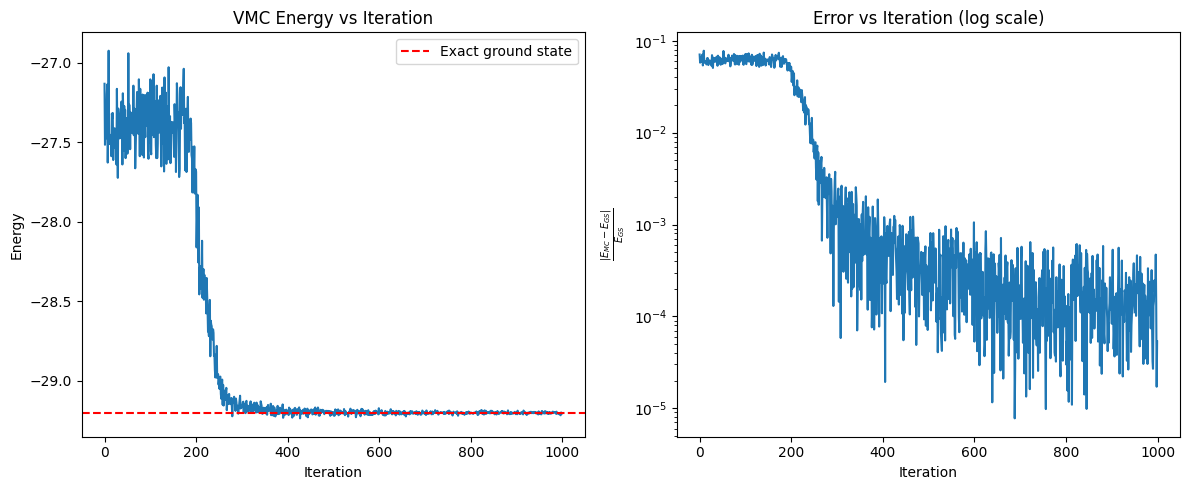

In [24]:
# Uncomment after running optimization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])
plt.axhline(y=e_gs, color='r', linestyle='--', label='Exact ground state')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VMC Energy vs Iteration')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['Mean'] - e_gs)/np.abs(e_gs))
plt.xlabel('Iteration')
plt.ylabel(r'$\frac{|E_{MC}- E_{GS}|}{E_{GS}}$')
plt.title('Error vs Iteration (log scale)')
plt.tight_layout()

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vmc_models(loggers: dict, e_gs: float):
    """
    loggers : dict nom_modele -> logger
    e_gs : énergie exacte du fondamental
    """
    plt.figure(figsize=(12, 5))

    # --- Énergie absolue ---
    plt.subplot(1, 2, 1)
    for name, logger in loggers.items():
        iters = logger.data['Energy']['iters']
        means = logger.data['Energy']['Mean']
        plt.plot(iters, means, label=name)
    plt.axhline(y=e_gs, color='r', linestyle='--', label='Exact ground state')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('VMC Energy vs Iteration')
    plt.legend()

    # --- Erreur relative (log-scale) ---
    plt.subplot(1, 2, 2)
    for name, logger in loggers.items():
        iters = logger.data['Energy']['iters']
        means = logger.data['Energy']['Mean']
        err = np.abs(means - e_gs) / np.abs(e_gs)
        plt.semilogy(iters, err, label=name)
    plt.xlabel('Iteration')
    plt.ylabel(r'$\frac{|E_{MC}- E_{GS}|}{|E_{GS}|}$')
    plt.title('Relative Error vs Iteration (log scale)')
    plt.legend()

    plt.tight_layout()
    plt.show()


c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


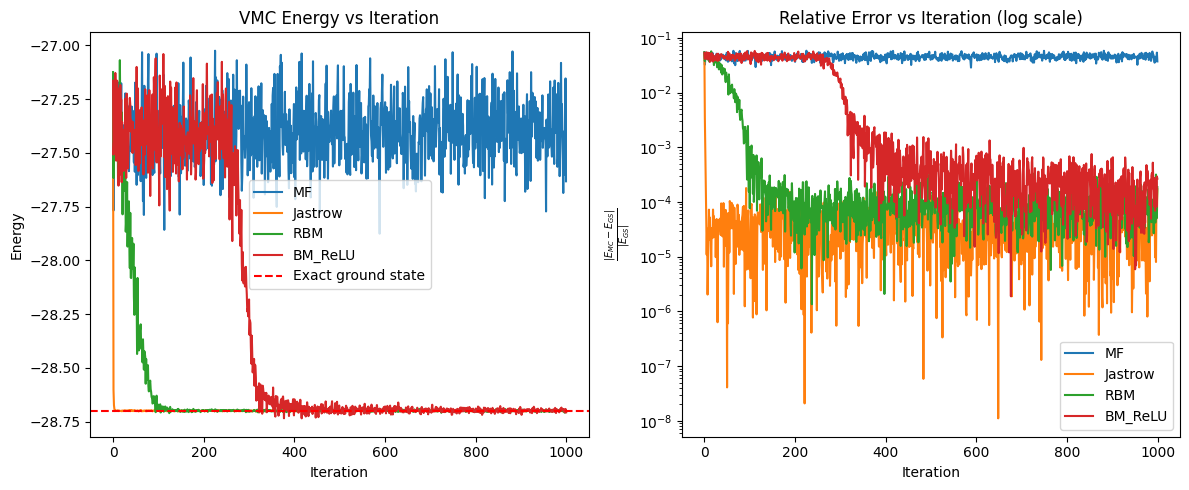

In [32]:
plot_vmc_models(loggers, e_gs)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_energy_vs_alpha(loggers, e_gs, betas, title="RBM-ReLU — Énergie vs itérations"):
    """
    loggers : dict {alpha : logger}
    e_gs : énergie exacte du fondamental
    alphas : liste ou tableau des valeurs de alpha testées
    """
    plt.figure(figsize=(10, 5))

    # Colormap
    cmap = cm.get_cmap("viridis", len(betas))
    norm = plt.Normalize(min(betas), max(betas))

    for i, beta in enumerate(sorted(betas)):
        logger = loggers[beta]
        iters = logger.data["Energy"]["iters"]
        energy = logger.data["Energy"]["Mean"]
        plt.plot(
            iters,
            energy,
            color=cmap(norm(beta)),
            label=f"beta = {beta}"
        )

    plt.axhline(y=e_gs, color="r", linestyle="--", label="État fondamental exact")
    plt.xlabel("Itération")
    plt.ylabel("Énergie")
    plt.title(title)
    plt.legend()
    plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        label="Valeur de beta"
    )
    plt.tight_layout()
    plt.show()


100%|██████████| 500/500 [00:23<00:00, 21.20it/s]
C:\Users\mouts\AppData\Local\Temp\ipykernel_25880\1625756818.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(alphas))
c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\mouts\OneDrive\Bureau\X\2A\PSC\NQS\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

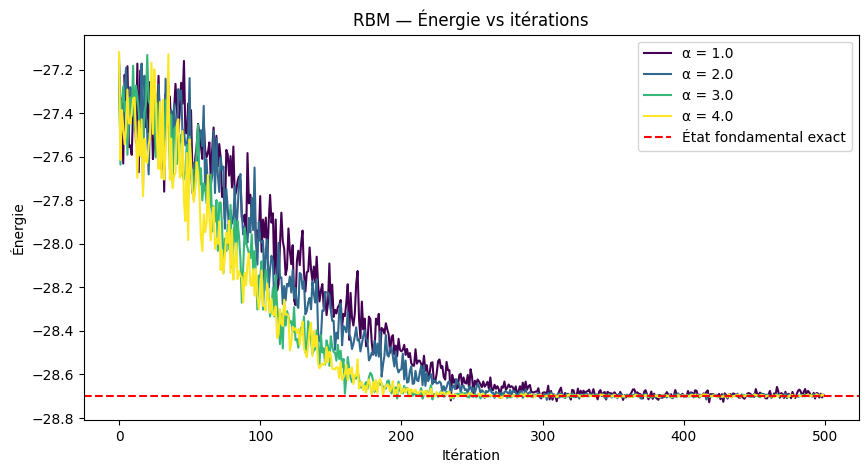

In [ ]:
alphas = [1.0, 2.0, 3.0, 4.0]
loggers = {}

for alpha in alphas:
    model = BM(alpha=alpha)
    logger, model, params, sampler = optimize(
        model, sampler, hamiltonian_jax,
        chain_length, n_iters=500, learning_rate=1e-2
    )
    loggers[alpha] = logger

plot_energy_vs_alpha(loggers, e_gs, alphas=alphas)


TypeError: plot_energy_vs_alpha() got an unexpected keyword argument 'alphas'

100%|██████████| 500/500 [00:50<00:00,  9.87it/s]
C:\Users\mouts\AppData\Local\Temp\ipykernel_25880\3201951504.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(betas))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

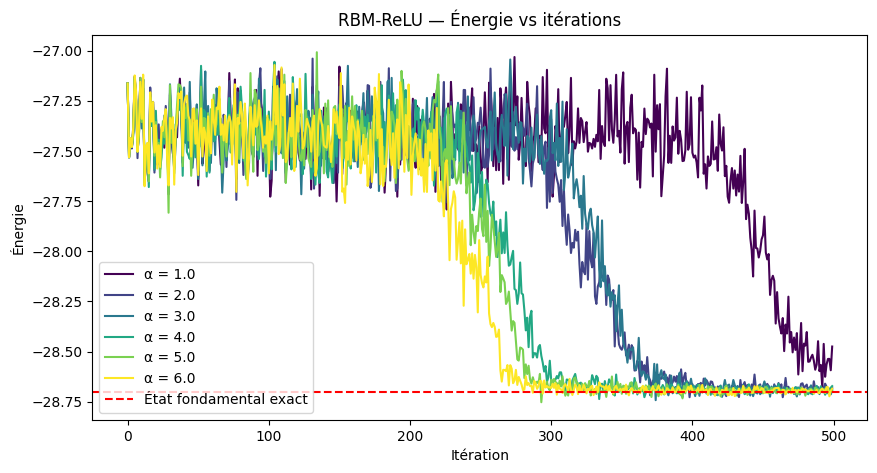

In [ ]:

betas = [1.0,2.0,3.0,4.0,5.0,6.0]
loggers = {}

for beta in betas:
    model = BM_ReLU(alpha=4.0, beta = beta)
    logger, model, params, sampler = optimize(
        model, sampler, hamiltonian_jax,
        chain_length, n_iters=500, learning_rate=1e-1
    )
    loggers[beta] = logger



C:\Users\mouts\AppData\Local\Temp\ipykernel_25880\3047784089.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(betas))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

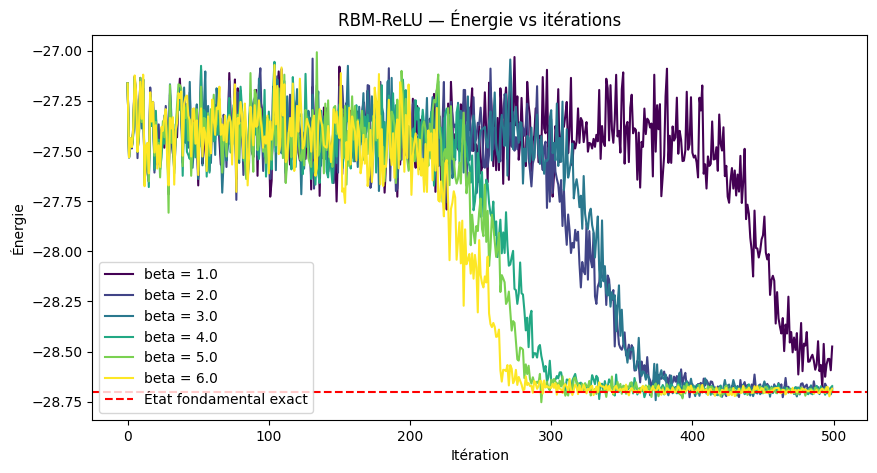

In [45]:
plot_energy_vs_alpha(loggers, e_gs, betas=betas)


### 10.1 Better Optimizers with Optax

You can use more sophisticated optimizers from the [optax](https://optax.readthedocs.io/en/latest/) library:

In [ ]:
import optax

def optax_optimize(model, sampler, ham, optimizer, n_iters=500):
    # Initialize
    parameters = model.init(jax.random.key(0), np.ones((hi.size,)))
    sampler_state = sampler.init_state(model, parameters, seed=1)
    learning_rate = 5e-3
    # Logging
    logger = nk.logging.RuntimeLog()

    for i in tqdm(range(n_iters)):
        # sample
        sampler_state = sampler.reset(model, parameters, state=sampler_state)
        samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)

        # compute energy and gradient
        E, E_grad = estimate_energy_and_gradient(model, parameters, ham, samples)

        # update parameters
        updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
        parameters = optax.apply_updates(parameters, updates)
        # parameters = jax.tree.map(lambda x,y: x-learning_rate*y, parameters, E_grad)

        # log energy
        logger(step=i, item={'Energy':E})
    return logger, model, parameters, sampler

Exercices:
- Implémenter l'estimateur du gradient
- Comparer Mean Field, Jastrow et RBM
- éventuellement comparer différents alpha pour la RBM, et différents learning rate

Faire des graphes de totues les quantités.

Remarque importante : La meilleure estimation est toujours la plus basse (toutes les estimations sont des bornes supérieures).
Jastrow --> problème, on ne peut pas augmenter le nombre de paramètres. 


A faire : complexité sous toute forme, vitesse en fonction de learning rate, taille des échantillon , couches, insérer des couches, changer d'optimiseur Adam/Optax.


Relire le gradient Naturel ( en comparaison avec sgd ) pour la prochaine fois, si on a le temps essayer de l'implémenter.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import netket as nk

# --- 1) Modèles à comparer (adapter si besoin) ---


# Learning-rate par modèle (fallback sur lr_def si absent)
per_model_lr = {"MF":5e-3, "Jastrow":1e-2, "RBM":2e-2, "BM_ReLU":1e-1}
lr_def = 1e-2

# --- 2) Builder Hamiltonien (remplace par le tien si besoin) ---
def make_hamiltonian(hi, g):
    # Exemple : Ising transverse champ h=1
    return nk.operator.Ising(hilbert=hi, graph=g, h=1.0, J=1.0)

# --- 3) Choix géométrie ---
def make_graph(n_sites, geometry="chain", pbc=True):
    if geometry == "chain":
        return nk.graph.Chain(length=n_sites, pbc=pbc)
    elif geometry == "triangular":
        # n_sites = Lx*Ly. Choisis Lx,Ly (ici carré si possible)
        L = int(np.sqrt(n_sites))
        assert L*L == n_sites, "Choisir n_sites = Lx*Ly carré pour le triangular."
        return nk.graph.Triangular(extent=[L, L], pbc=pbc)
    else:
        raise ValueError("geometry ∈ {'chain','triangular'}")

# --- 4) Benchmark temps ---
def benchmark_times(
    sizes, models, geometry="chain",
    n_chains=20, chain_length_per_chain=50,
    n_iters=300
):
    times = {name: [] for name in models.keys()}

    for n in sizes:
        
        
        g  = make_graph(n, geometry=geometry, pbc=True)
        hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
        H  = make_hamiltonian(hi, g)

        # sampler neuf à chaque taille
        sampler_base = nk.sampler.MetropolisSampler(
            hi, nk.sampler.rules.LocalRule(), n_chains=n_chains
        )
        chain_length = max(1, chain_length_per_chain)  # steps par chaîne

        for name, model in models.items():
            # sampler neuf par modèle (évite contamination d'état)
            sampler = nk.sampler.MetropolisSampler(
                hi, nk.sampler.rules.LocalRule(), n_chains=n_chains
            )
            lr = per_model_lr.get(name, lr_def)

            t0 = time.perf_counter()
            logger, mdl, params, sampler = optimize(
                model,
                sampler,
                H,                   # ou hamiltonian_jax si tu as déjà la version JAX
                chain_length,
                n_iters=n_iters,
                learning_rate=lr,
            )
            t1 = time.perf_counter()

            times[name].append(t1 - t0)
            print(f"[n={n:3d}] {name:8s}  time = {t1-t0:.2f}s")

    return times

# --- 5) Exécution du benchmark ---
sizes = [8, 12, 16, 20, 24, 28, 32]          # adapter
times = benchmark_times(
    sizes, models,
    geometry="chain",         # "triangular" possible (avec n carré)
    n_chains=20,
    chain_length_per_chain=50,
    n_iters=300               # réduire si besoin pour aller vite
)

# --- 6) Plot temps vs n_sites ---
plt.figure(figsize=(8,5))
for name, t in times.items():
    plt.plot(sizes, t, marker="o", label=name)
plt.xlabel("n_sites")
plt.ylabel("Temps (s)")
plt.title("Temps empirique vs n_sites par modèle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 300/300 [00:02<00:00, 131.01it/s]


[n=  8] MF        time = 2.30s


ScopeParamShapeError: Initializer expected to generate shape (9, 9) but got shape (8, 8) instead for parameter "J" in "/". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)